# Understanding Customer

## Setting Up saved Folders

In [37]:
import os
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

MODELS_DIRECTORY = os.path.join("/kaggle/working", "models")
DATA_FOLDER = "/kaggle/input/understandingcustomer"
ACC_THRESHOLD = 0.7
if not os.path.exists(MODELS_DIRECTORY):
    os.makedirs(MODELS_DIRECTORY, exist_ok=True)

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [39]:
import pandas as pd

df = pd.read_csv(f"{DATA_FOLDER}/intents_train.csv")
df = df.dropna()

df = df.drop(df[df["intent"] == "Welcome Intent"].index)

## Preprocess

### plot disturbution of the Data

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

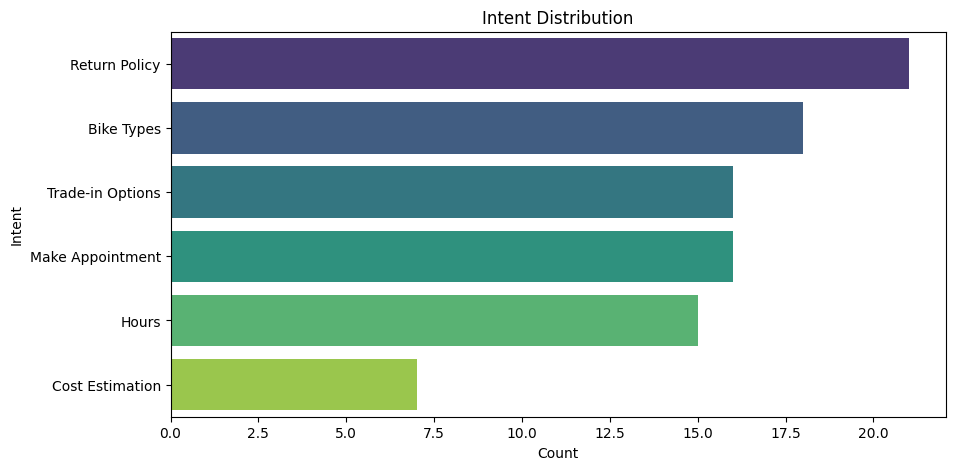

In [41]:
def distribution(df):
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df['intent'], order=df['intent'].value_counts().index, palette="viridis")
    plt.title("Intent Distribution")
    plt.xlabel("Count")
    plt.ylabel("Intent")
    plt.show()

distribution(df)

### Balance Data

In [42]:
from imblearn.over_sampling import RandomOverSampler

In [43]:
X = df["text"]
y = df["intent"]

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.to_frame(), y)

df = pd.DataFrame({"text": X_resampled["text"], "intent": y_resampled})

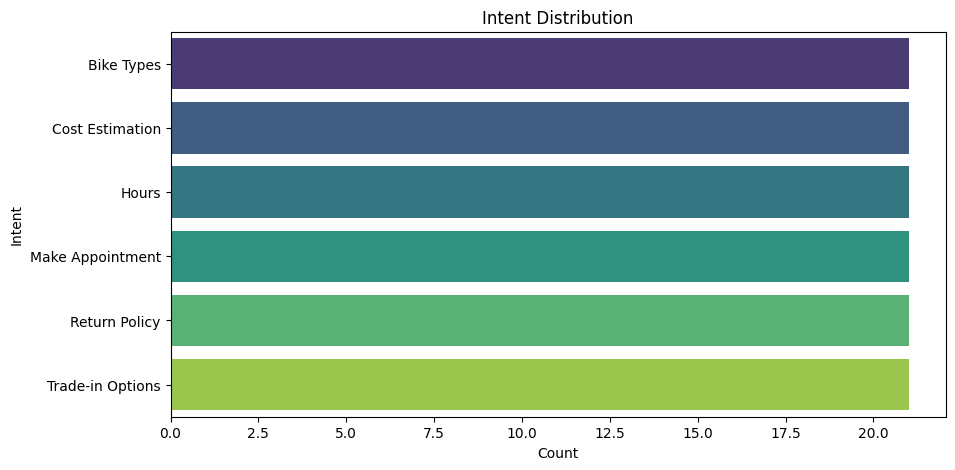

In [44]:
distribution(df)

## RNN Model

### Preprocess For RNN

In [45]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

Workingdf = df.copy()
RNNtokenizer = Tokenizer()
RNNtokenizer.fit_on_texts(Workingdf['text'])
X = RNNtokenizer.texts_to_sequences(Workingdf['text'])

max_sequence_length = 100
X = pad_sequences(X, maxlen=max_sequence_length)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Workingdf['intent'])
unique_labels_num = len(np.unique(y))
y = to_categorical(y, num_classes=unique_labels_num)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

RNNpathModel = os.path.join(MODELS_DIRECTORY,"RNNclassifier.h5")
RNNmodel = Sequential()

embedding_dim = 100
RNNmodel.add(Embedding(input_dim=len(RNNtokenizer.word_index) + 1, output_dim=embedding_dim))
RNNmodel.add(SimpleRNN(128, activation='tanh'))
RNNmodel.add(Dense(len(np.unique(Workingdf['intent'])), activation='softmax'))

RNNmodel.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Workingdf = None

In [47]:
_ = RNNmodel.fit(X_train, y_train, epochs=15, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.1368 - loss: 1.8121 - val_accuracy: 0.1538 - val_loss: 1.7412
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4907 - loss: 1.5738 - val_accuracy: 0.4231 - val_loss: 1.6666
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6936 - loss: 1.3194 - val_accuracy: 0.5385 - val_loss: 1.5503
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8454 - loss: 1.1283 - val_accuracy: 0.5000 - val_loss: 1.4247
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9064 - loss: 0.8813 - val_accuracy: 0.6154 - val_loss: 1.3035
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9388 - loss: 0.6130 - val_accuracy: 0.5769 - val_loss: 1.1990
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9906 - loss: 0.4848 - val_accuracy: 0.6538 - val_loss: 1.0625
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9872 - loss: 0.3339 - val_accuracy: 0.7692 - 

In [48]:
test_loss, test_accuracy = RNNmodel.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
if not os.path.exists(RNNpathModel):
    print("saving RNN model")
    RNNmodel.save(RNNpathModel)
else:
    test_RNNmodel = load_model(RNNpathModel)
    loaded_test_loss, loaded_test_accuracy = RNNmodel.evaluate(X_test, y_test)
    if loaded_test_accuracy < test_accuracy:
        print("removing old RNN model")
        os.remove(RNNpathModel)
        print("saving RNN model")
        RNNmodel.save(RNNpathModel)
    else:
        print("loading RNN model")
        RNNmodel = load_model(RNNpathModel)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.7692 - loss: 0.7437
Test Loss: 0.7436580657958984
Test Accuracy: 76.92%
saving RNN model


In [49]:
new_text = "Do you match prices?"
def RNN_predict(text):
    new_sequence = RNNtokenizer.texts_to_sequences([text])
    new_padded = pad_sequences(new_sequence, maxlen=max_sequence_length)

    predictions = RNNmodel.predict(new_padded)
    if predictions[0][np.argmax(predictions)-1] < ACC_THRESHOLD:
        predicted_class = label_encoder.inverse_transform([np.argmax(predictions)])[0]
    else:
        predicted_class = "Fallback Intent"
    return predicted_class

print(f"Predicted Intent: {RNN_predict(new_text)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Predicted Intent: Hours


## LSTM

In [50]:
!python -m spacy download en_core_web_sm
!pip install spacy-lookups-data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.5 MB/s eta 0:00:00:00:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 16.6 MB/s eta 0:00:00:00:0100:01


In [51]:

from tqdm import tqdm
import spacy
from spacy.training import Example
import spacy_lookups_data
import random

Workingdf = df.copy()
unique_intents = Workingdf["intent"].unique()
intent_labels = {intent: i for i, intent in enumerate(unique_intents)}
training_data = [(row["text"], {"cats": {intent: (intent == row["intent"]) for intent in unique_intents}})
                 for _, row in Workingdf.iterrows()]
Workingdf = None
train_data, test_data = train_test_split(training_data, test_size=0.2, random_state=42)

spacy.prefer_gpu()
LSTM_model = spacy.load("en_core_web_sm")
textcat = LSTM_model.add_pipe("textcat", last=True)
for intent in unique_intents:
    textcat.add_label(intent)

LSTM_model.begin_training()
n_iter = 15
optimizer = LSTM_model.initialize()
loss = 99.99
acc = 99.99
for i in range(n_iter):
    random.shuffle(train_data)
    losses = {}
    for text, annotations in tqdm(train_data, desc=f"Epoch {i+1}/{n_iter} ... losses [{loss:.2f}]"):
        example = Example.from_dict(LSTM_model.make_doc(text), annotations)
        LSTM_model.update([example], drop=0.3, losses=losses)
    loss = losses['textcat']

[2025-03-12 16:47:32,055] [INFO] Added vocab lookups: lexeme_norm
[2025-03-12 16:47:32,056] [INFO] Created vocabulary
[2025-03-12 16:47:32,057] [INFO] Finished initializing nlp object
[2025-03-12 16:47:45,870] [INFO] Added vocab lookups: lexeme_norm
[2025-03-12 16:47:45,871] [INFO] Created vocabulary
[2025-03-12 16:47:45,872] [INFO] Finished initializing nlp object
Epoch 15/15 ... losses [0.18]: 100%|██████████| 100/100 [00:04<00:00, 20.32it/s]


In [52]:
def get_LSTMaccuracy(model, data):
    y_true = []
    y_pred = []

    for text, annotations in data:
        doc = model(text)
        predicted_label = max(doc.cats, key=doc.cats.get)
        true_label = max(annotations["cats"], key=annotations["cats"].get)

        y_true.append(true_label)
        y_pred.append(predicted_label)

    return accuracy_score(y_true, y_pred)

current_accuracy = get_LSTMaccuracy(LSTM_model, test_data)
print(f"Test Accuracy: {current_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)
/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Test Accuracy: 0.7692


In [53]:
import shutil

LSTM_PATH = os.path.join(MODELS_DIRECTORY, "LSTMclassifier")

if not os.path.exists(LSTM_PATH):
    print("Saving LSTM model")
    LSTM_model.to_disk(LSTM_PATH, exclude=["vectors"])
else:
    spacy.prefer_gpu()
    tmp_LSTM_md = spacy.load(LSTM_PATH)
    tmp_acc = get_LSTMaccuracy(tmp_LSTM_md, test_data)
    if current_accuracy > tmp_acc:
        print("Removing old model")
        shutil.rmtree(LSTM_PATH)
        print("Saving LSTM model")
        LSTM_model.to_disk(LSTM_PATH, exclude=["vectors"])
    else:
        LSTM_model = tmp_LSTM_md

    del tmp_LSTM_md

Saving LSTM model


In [54]:
new_text = "How much to repair my bike?"
def LSTM_predict(model, text):
    doc = model(text)
    predicted_label = max(doc.cats, key=doc.cats.get)
    confidence_score = doc.cats[predicted_label]
    if doc.cats[predicted_label] > ACC_THRESHOLD:
        predicted_class = predicted_label
    else:
        predicted_class = "Fallback Intent"

    return predicted_class

print(f"Predicted Intent: {LSTM_predict(LSTM_model, new_text)}")

Predicted Intent: Trade-in Options


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)
/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


## BERT

In [55]:
from datasets import Dataset

Workingdf = df.copy()
unique_labels = Workingdf["intent"].unique()
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
Workingdf["intent"] = Workingdf["intent"].map(label2id)
Workingdf.rename(columns={"intent": "labels"}, inplace=True)
train_df, test_df = train_test_split(Workingdf, test_size=0.2, stratify=Workingdf["labels"], random_state=42)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [56]:
def tokenize_function(examples,tokenizer):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

In [57]:
from transformers import DistilBertTokenizer


PRETRAINED_MODEL = "Falconsai/intent_classification"

BERTtokenizer = DistilBertTokenizer.from_pretrained(PRETRAINED_MODEL)

train_dataset = train_dataset.map(lambda x: tokenize_function(x, BERTtokenizer), batched=True)
test_dataset = test_dataset.map(lambda x: tokenize_function(x, BERTtokenizer), batched=True)

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

In [58]:
from transformers import AutoConfig, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch

BERT_PATH = os.path.join(MODELS_DIRECTORY, "BERTclassifier")

config = AutoConfig.from_pretrained(PRETRAINED_MODEL)

config.num_labels = len(unique_labels)

BERTmodel = DistilBertForSequenceClassification.from_pretrained(
        PRETRAINED_MODEL,
        config=config,
        ignore_mismatched_sizes=True
    )
BERTmodel.config.id2label = id2label
BERTmodel.config.label2id = label2id

if torch.cuda.is_available():
    BERTmodel.to('cuda')


training_args = TrainingArguments(
        output_dir=BERT_PATH,
        run_name="Intent Classifier",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=20,
        weight_decay=0.01,
        logging_dir=f"{BERT_PATH}/logs",
    )

trainer = Trainer(
        model=BERTmodel,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=BERTtokenizer
    )

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Falconsai/intent_classification and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([15]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([15, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
import wandb

wandb.login(key="Your_API_KEY")

print("Training...")
trainer.train()
print("Training Finished")

BERTmodelPATH = os.path.join(BERT_PATH, "model")
if not os.path.exists(BERTmodelPATH):
    print("saving BERT model")
    BERTmodel.save_pretrained(BERTmodelPATH)
BERTtokenizerPATH = os.path.join(BERT_PATH, "tokenizer")
if not os.path.exists(BERTtokenizerPATH):
    print("saving BERT tokenizer")
    BERTtokenizer.save_pretrained(BERTtokenizerPATH)

wandb: WARNING Path /kaggle/input/bert/other/default/1/savedmodel/wandb/ wasn't writable, using system temp directory.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING Path /kaggle/input/bert/other/default/1/savedmodel/wandb/ wasn't writable, using system temp directory
wandb: Currently logged in as: sboof (sboof-1337). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Training...


Epoch,Training Loss,Validation Loss
1,No log,1.601168
2,No log,1.363231
3,No log,1.201339
4,No log,1.005803
5,No log,0.870587
6,No log,0.857736
7,No log,0.675262
8,No log,0.617236
9,No log,0.553360
10,No log,0.503094


Training Finished
saving BERT model
saving BERT tokenizer


In [60]:
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()

accuracy = accuracy_score(test_dataset["labels"], preds)
print(f"Test Accuracy: {accuracy*100:.4f}%")

Test Accuracy: 88.4615%


In [61]:
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
import pandas as pd
import torch

def predict_from_file(file_path, model_dir, output_dir="/kaggle/working"):
    modelBERT = os.path.join(model_dir, "model")
    model = DistilBertForSequenceClassification.from_pretrained(modelBERT)
    tokenizerBERT = os.path.join(model_dir, "tokenizer")
    tokenizer = DistilBertTokenizer.from_pretrained(tokenizerBERT)

    df = pd.read_csv(file_path)

    if "text" not in df.columns:
        raise ValueError("CSV file must have a 'text' column")

    inputs = tokenizer(df["text"].tolist(), return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    predictions = torch.argmax(probs, dim=1).tolist()
    confidence_scores = probs.max(dim=1).values.tolist()

    id2label = model.config.id2label
    predicted_labels = [id2label[pred] if confidence_scores[key] > ACC_THRESHOLD else "Fallback Intent" for key, pred in enumerate(predictions)]

    df["predected_intents"] = predicted_labels
    output_file = os.path.join(output_dir, file_path.replace(".csv", "_predictions.csv").split('/')[-1])
    df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

    return df

In [62]:
pretrained_model_path = "/kaggle/input/bert/other/default/1/savedmodel"

predected_data = predict_from_file("/kaggle/input/understandingcustomer/intents_train.csv", pretrained_model_path)
predected_data

Predictions saved to /kaggle/working/intents_train_predictions.csv


,text,intent,predected_intents
0,Carbon fiber bike,Bike Types,Bike Types
1,budget bikes,Bike Types,Bike Types
2,professional bikes,Bike Types,Bike Types
3,bikes for men,Bike Types,Bike Types
4,bikes for women,Bike Types,Bike Types
...,...,...,...
89,I'd like to learn the trade-in options.,Trade-in Options,Trade-in Options
90,Do you buy used bikes?,Trade-in Options,Trade-in Options
91,Do you take trade-ins?,Trade-in Options,Trade-in Options
92,Do you buy bikes?,Trade-in Options,Trade-in Options


In [63]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(predected_data["intent"], predected_data["predected_intents"])
print(f"Test Accuracy: {accuracy*100:.4f}%")

Test Accuracy: 95.7447%
